#### Настройка окружения и конфиг


In [ ]:
# Imports
import os

import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
from dask.diagnostics import ProgressBar
from dask.distributed import Client

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Paths (подставь свои)
DATA_DIR = "../data/raw"
TRAIN_PATH = os.path.join(DATA_DIR, "train-dset-001.parquet")
TEST_PATH = os.path.join(
    DATA_DIR, "test-dset-small.parquet"
)  # или test-dset.parquet если у тебя полный тест

client = Client("tcp://127.0.0.1:8788")
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 9.31 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38433,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:43427,Total threads: 1
Dashboard: http://127.0.0.1:37041/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:38777,


2025-09-23 02:32:44,099 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f6bd133c01027e5e2de36d46ad1fa48d initialized by task ('shuffle-transfer-f6bd133c01027e5e2de36d46ad1fa48d', 2) executed on worker tcp://127.0.0.1:43427
2025-09-23 02:32:44,831 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f6bd133c01027e5e2de36d46ad1fa48d deactivated due to stimulus 'task-finished-1758569564.829175'


#### Генерация сэмпла


In [2]:
import numpy as np

RANDOM_STATE = 42
DEBUG_QUERIES = 60000
DEBUG_OUT = "../data/transformed/train-debug.parquet"

train_dd = dd.read_parquet(TRAIN_PATH, engine="pyarrow")

with ProgressBar():
    uniq_q = train_dd[["query_id"]].drop_duplicates().compute()
    uniq_q = uniq_q.sample(n=DEBUG_QUERIES, random_state=RANDOM_STATE)

    qset = set(uniq_q["query_id"].tolist())
    debug_dd = train_dd[train_dd["query_id"].isin(qset)]

    debug_dd.to_parquet(DEBUG_OUT)

#### Загрузка данных для EDA


In [ ]:
USE_COLS = [
    "query_id",
    "item_id",
    "query_text",
    "item_title",
    "item_description",
    "query_cat",
    "query_mcat",
    "query_loc",
    "item_cat_id",
    "item_mcat_id",
    "item_loc",
    "price",
    "item_query_click_conv",
    "item_contact",
]

train_dd = dd.read_parquet(DEBUG_OUT, columns=USE_COLS, engine="pyarrow")
test_dd = dd.read_parquet(
    TEST_PATH, columns=[c for c in USE_COLS if c != "item_contact"], engine="pyarrow"
)

CATEG_COLS = [
    "query_cat",
    "query_mcat",
    "query_loc",
    "item_cat_id",
    "item_mcat_id",
    "item_loc",
]
for c in CATEG_COLS:
    if c in train_dd.columns:
        train_dd[c] = train_dd[c].astype("category")
    if c in test_dd.columns:
        test_dd[c] = test_dd[c].astype("category")

with ProgressBar():
    print("Train rows (approx):", train_dd.shape[0].compute())
    print("Test rows  (approx):", test_dd.shape[0].compute())

train_dd.head(3)


Train rows (approx): 342991
Test rows  (approx): 335348


,query_id,item_id,query_text,item_title,item_description,query_cat,query_mcat,query_loc,item_cat_id,item_mcat_id,item_loc,price,item_query_click_conv,item_contact
460,184,3500509301,покос травы,Покос травы,"Покос травы возле дома, на дачном участке или ...",114.0,1178215.0,633270.0,114,1178215,633270,500.0,0.016,0.0
461,184,7238120547,покос травы,Спил деревьев. Расчистка участков,"Спил деревьев, без повреждения крыш и коммуник...",114.0,1178215.0,633270.0,114,1178215,633270,500.0,0.035,1.0
462,184,2407415937,покос травы,Покос травы тримером,Покос травы любой сложности. Цена зависит от о...,114.0,1178215.0,633270.0,114,1178215,633270,100.0,0.045,0.0


#### Sanity checks

-   Проверка уникальности пар (query_id, item_id).
-   Убедимся, что в тесте нет `item_contact`.
-   Проверим, что нет пропусков в ключевых ID.


In [ ]:
with ProgressBar():
    n_pairs = train_dd[["query_id", "item_id"]].drop_duplicates().shape[0].compute()
    n_rows = train_dd.shape[0].compute()
    print(
        f"Train unique (query_id,item_id): {n_pairs}/{n_rows} (дубликаты: {n_rows - n_pairs})"
    )

    null_ids = (
        train_dd[train_dd["item_id"].isna() | train_dd["query_id"].isna()]
        .shape[0]
        .compute()
    )
    print("Null IDs in train:", null_ids)

    print("item_contact in test columns:", "item_contact" in test_dd.columns)


Train unique (query_id,item_id): 342991/342991 (дубликаты: 0)
Null IDs in train: 0
item_contact in test columns: False


-   Считаем долю пропусков на колонку в train/test.
-   Визуализируем столбиком (только агрегаты в pandas).


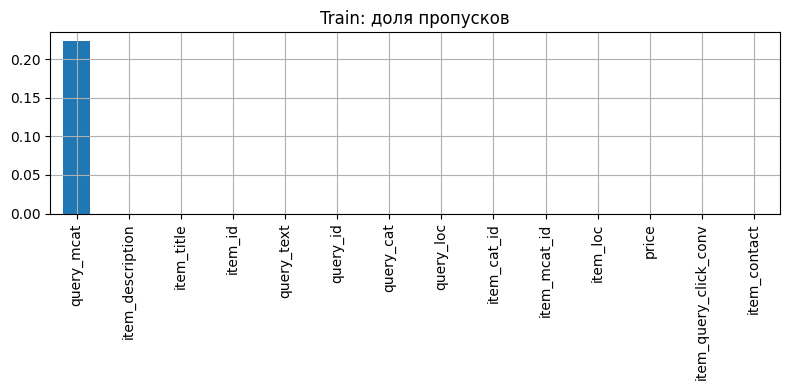

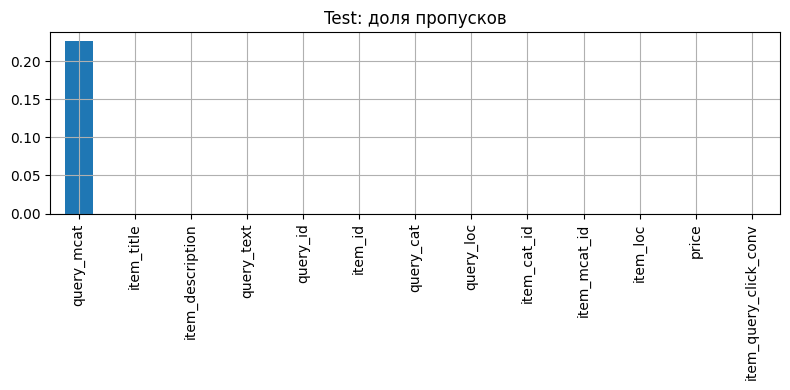

(query_mcat          0.223382
 item_description    0.000012
 item_title          0.000012
 item_id             0.000000
 query_text          0.000000
 query_id            0.000000
 query_cat           0.000000
 query_loc           0.000000
 item_cat_id         0.000000
 item_mcat_id        0.000000
 dtype: float64,
 query_mcat          0.226705
 item_title          0.000006
 item_description    0.000006
 query_text          0.000000
 query_id            0.000000
 item_id             0.000000
 query_cat           0.000000
 query_loc           0.000000
 item_cat_id         0.000000
 item_mcat_id        0.000000
 dtype: float64)

In [ ]:
def null_share(ddf):
    return (ddf.isna().sum() / ddf.shape[0]).compute().sort_values(ascending=False)


train_nulls = null_share(train_dd)
test_nulls = null_share(test_dd)

plt.figure()
train_nulls.plot(kind="bar")
plt.title("Train: доля пропусков")
plt.tight_layout()
plt.show()

plt.figure()
test_nulls.plot(kind="bar")
plt.title("Test: доля пропусков")
plt.tight_layout()
plt.show()

train_nulls.head(10), test_nulls.head(10)


##### Баланс таргета, распределение по запросам


Global positive rate (item_contact): 0.0445


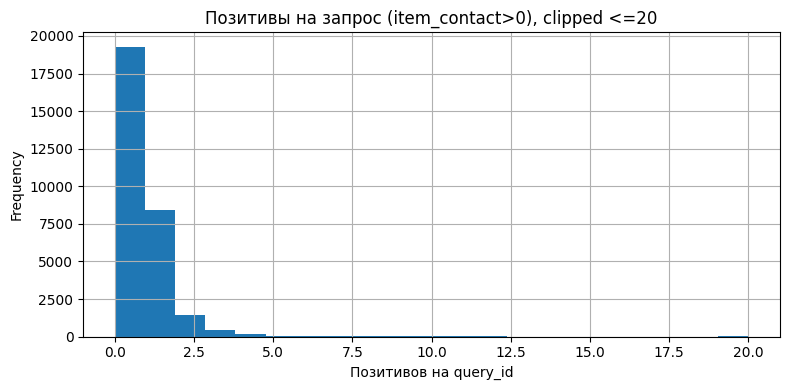

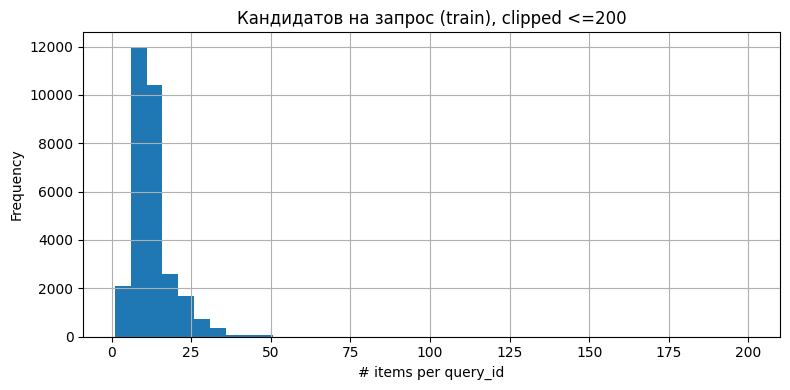

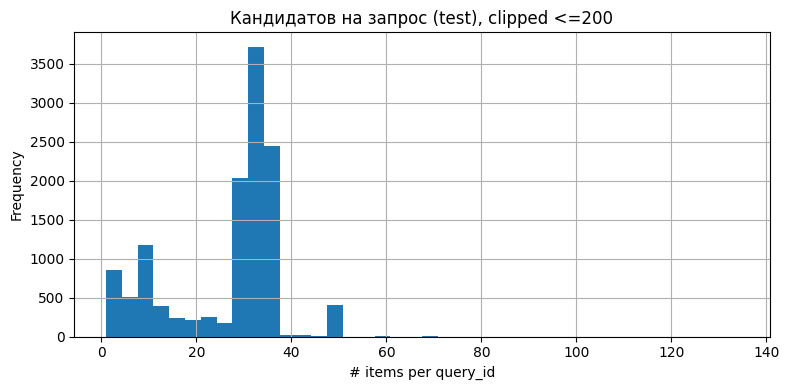

In [ ]:
with ProgressBar():
    pos_rate = train_dd["item_contact"].mean().compute()
    print(f"Global positive rate (item_contact): {pos_rate:.4f}")

    per_q = (
        train_dd.groupby("query_id")["item_contact"].agg("sum").compute().astype(int)
    )
    plt.figure()
    per_q.clip(0, 20).plot(kind="hist", bins=21)
    plt.title("Позитивы на запрос (item_contact>0), clipped <=20")
    plt.xlabel("Позитивов на query_id")
    plt.tight_layout()
    plt.show()

    items_per_q_train = train_dd.groupby("query_id")["item_id"].size().compute()
    plt.figure()
    items_per_q_train.clip(0, 200).plot(kind="hist", bins=40)
    plt.title("Кандидатов на запрос (train), clipped <=200")
    plt.xlabel("# items per query_id")
    plt.tight_layout()
    plt.show()

    items_per_q_test = test_dd.groupby("query_id")["item_id"].size().compute()
    plt.figure()
    items_per_q_test.clip(0, 200).plot(kind="hist", bins=40)
    plt.title("Кандидатов на запрос (test), clipped <=200")
    plt.xlabel("# items per query_id")
    plt.tight_layout()
    plt.show()


##### Базовые текстовые статистики


column,item_description,item_title,query_text
stat,,,
chars_95p,1000.00,49.00,31.00
chars_mean,472.10,29.62,16.29
words_95p,154.00,8.00,5.00
words_mean,67.52,4.48,2.45


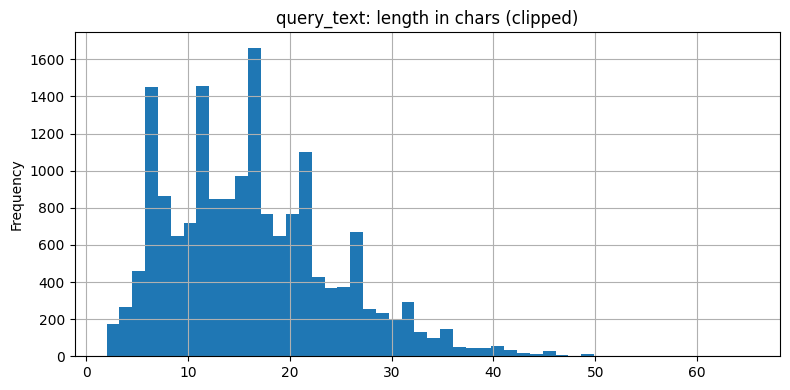

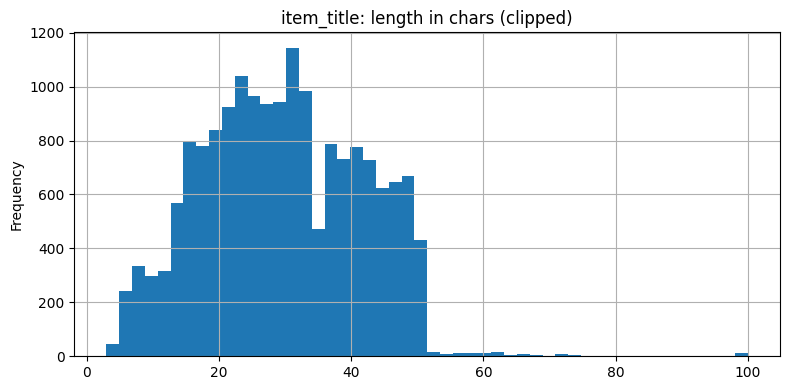

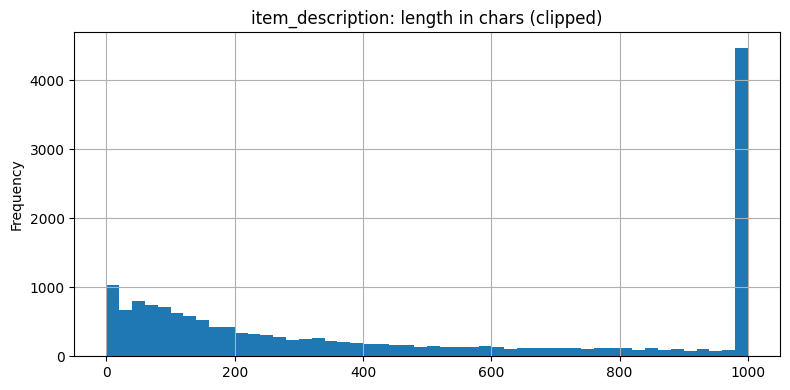

In [ ]:
import pandas as pd


def str_len_series(ddf, col, mode="chars"):
    """
    Возвращает dask.Series с длинами и dtype=float64 (чтобы quantile не падал).
    """
    s = ddf[col].fillna("")
    if mode == "chars":
        out = s.str.len()
    elif mode == "words":
        out = s.str.split().map_partitions(lambda x: x.apply(len))
    else:
        raise ValueError("mode must be 'chars' or 'words'")
    return out.astype("float64")  # важно для совместимости с quantile


with ProgressBar():
    txt_cols = ["query_text", "item_title", "item_description"]
    agg = {}
    for c in txt_cols:
        # chars
        chars = str_len_series(train_dd, c, "chars")
        agg[(c, "chars_mean")] = chars.mean()
        agg[(c, "chars_95p")] = chars.quantile(0.95)  # без interpolation
        # words
        words = str_len_series(train_dd, c, "words")
        agg[(c, "words_mean")] = words.mean()
        agg[(c, "words_95p")] = words.quantile(0.95)  # без interpolation

    text_vals = dd.compute(*agg.values())
    rows = []
    for (col, stat), val in zip(agg.keys(), text_vals):
        rows.append({"column": col, "stat": stat, "value": float(val)})

    text_stats = (
        pd.DataFrame(rows)
        .pivot(index="stat", columns="column", values="value")
        .sort_index()
    )
    display(text_stats.round(2))


with ProgressBar():
    sample = train_dd.sample(frac=0.05, random_state=RANDOM_STATE)[
        txt_cols
    ].compute()  # ~5% в память
    for c in txt_cols:
        plt.figure()
        sample[c].fillna("").str.len().clip(0, 2000).plot(kind="hist", bins=50)
        plt.title(f"{c}: length in chars (clipped)")
        plt.tight_layout()
        plt.show()


##### Цена и клики

Проверим, что у цены и кликов базовые распределения


price null share: 0.000, item_query_click_conv null share: 0.000


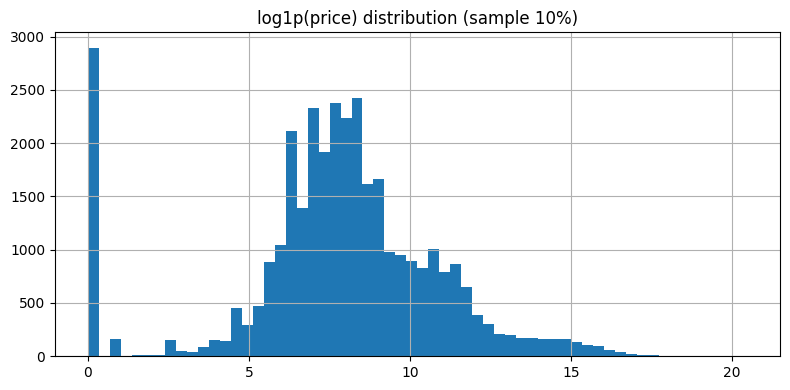

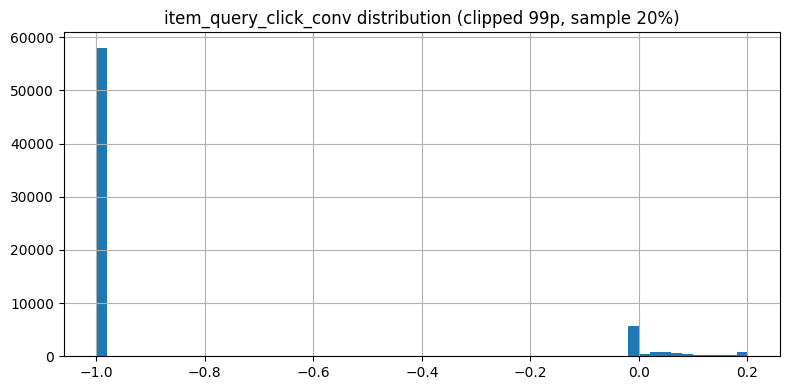

/home/syrenny/Desktop/avito-for-applicant/.venv/lib/python3.10/site-packages/dask/dataframe/dask_expr/_groupby.py:1562: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(


In [ ]:
with ProgressBar():
    price_null = train_dd["price"].isna().mean().compute()
    click_null = train_dd["item_query_click_conv"].isna().mean().compute()
    print(
        f"price null share: {price_null:.3f}, item_query_click_conv null share: {click_null:.3f}"
    )

    price_sample = (
        train_dd[["price"]]
        .dropna()
        .sample(frac=0.1, random_state=RANDOM_STATE)
        .compute()
    )
    log_price = np.log1p(price_sample["price"])
    plt.figure()
    plt.hist(log_price, bins=60)
    plt.title("log1p(price) distribution (sample 10%)")
    plt.tight_layout()
    plt.show()

    conv_sample = (
        train_dd[["item_query_click_conv"]]
        .dropna()
        .sample(frac=0.2, random_state=RANDOM_STATE)
        .compute()
    )
    plt.figure()
    plt.hist(
        conv_sample["item_query_click_conv"].clip(
            upper=np.percentile(conv_sample["item_query_click_conv"], 99)
        ),
        bins=60,
    )
    plt.title("item_query_click_conv distribution (clipped 99p, sample 20%)")
    plt.tight_layout()
    plt.show()

    med_price_per_cat = (
        train_dd.groupby("item_cat_id")["price"]
        .median()
        .compute()
        .sort_values(ascending=False)
    )
    med_price_per_cat.head(10)


In [ ]:
from dask.diagnostics import ProgressBar


def match_share(ddf, qa: str, ia: str, lower: bool = True):
    """
    Доля совпадений между двумя колонками (поэлементно).
    - Преобразует обе колонки к pandas nullable string dtype.
    - Опционально приводит к нижнему регистру (уменьшает «ложные» несовпадения).
    - NaN считаются как несовпадение.
    Возвращает: dask Scalar (нужно .compute()).
    """
    a = ddf[qa].astype("string")
    b = ddf[ia].astype("string")
    if lower:
        a = a.str.lower()
        b = b.str.lower()
    return (a == b).mean()


with ProgressBar():
    cat_card = {}
    for c in [
        "query_cat",
        "query_mcat",
        "query_loc",
        "item_cat_id",
        "item_mcat_id",
        "item_loc",
    ]:
        if c in train_dd.columns:
            cat_card[c] = train_dd[c].nunique().compute()
    display(pd.Series(cat_card).sort_values(ascending=False))

    for qa, ia in [
        ("query_loc", "item_loc"),
        ("query_cat", "item_cat_id"),
        ("query_mcat", "item_mcat_id"),
    ]:
        if qa in train_dd.columns and ia in train_dd.columns:
            ms = match_share(train_dd, qa, ia).compute()
            print(f"Match share {qa} == {ia}: {ms:.3f}")


item_mcat_id    3242
item_loc        2862
query_loc       1045
query_mcat      1035
query_cat         63
item_cat_id       52
dtype: int64

Match share query_loc == item_loc: 0.000
Match share query_cat == item_cat_id: 0.000
Match share query_mcat == item_mcat_id: 0.000


,item_contact,price,item_query_click_conv,query_text_len,item_title_len,item_description_len
item_contact,1.000,-0.006,0.018,0.008,-0.001,-0.004
price,-0.006,1.000,0.004,0.004,0.003,0.028
item_query_click_conv,0.018,0.004,1.000,-0.099,-0.031,0.006
query_text_len,0.008,0.004,-0.099,1.000,0.202,0.110
item_title_len,-0.001,0.003,-0.031,0.202,1.000,0.371
item_description_len,-0.004,0.028,0.006,0.110,0.371,1.000


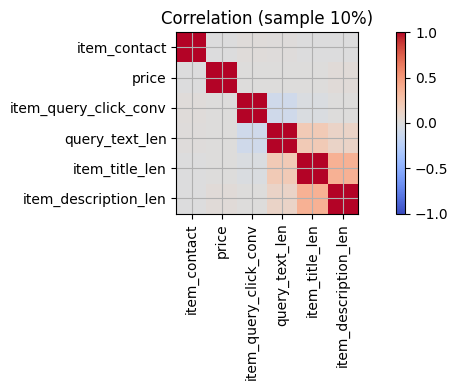

In [ ]:
with ProgressBar():
    num_df = (
        train_dd[
            [
                "item_contact",
                "price",
                "item_query_click_conv",
                "query_text",
                "item_title",
                "item_description",
            ]
        ]
        .sample(frac=0.1, random_state=RANDOM_STATE)
        .compute()
    )

for col in ["query_text", "item_title", "item_description"]:
    s = num_df[col].fillna("")
    num_df[col + "_len"] = s.str.len().astype(np.float32)
num_df = num_df.drop(columns=["query_text", "item_title", "item_description"])

corr = num_df.corr(numeric_only=True)
display(corr.round(3))

plt.figure()
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation (sample 10%)")
plt.tight_layout()
plt.show()
